In [2]:
!nvidia-smi

Mon Aug 12 09:54:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Setup

In [1]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf
if not tf.__version__.startswith('2.15'):
  !pip uninstall -y tensorflow
  !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph

In [1]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

2024-08-13 12:53:33.701301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Download dataset

In [2]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [3]:
def load_data(jsonData, dataFolderPath, training_or_test, filterString='0001'):
    images = []
    labels = []
    for sample in jsonData[training_or_test]:
        image = nib.load(dataFolderPath + sample['image'].removeprefix('.').replace(".csv",".nii.gz")).get_fdata()
        images.append(image)
        if training_or_test == 'training':
          label = nib.load(dataFolderPath + sample['label'].removeprefix('.').replace(".csv",".nii.gz")).get_fdata()
          labels.append(label)

    return np.array(images), np.array(labels)

In [15]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
  data_json = json.load(file)
dataFolder = './AbdomenCTCT'
training_images_raw, training_labels_raw = load_data(data_json, dataFolder, 'training')

In [16]:
training_images_raw.shape

(30, 192, 160, 256)

In [17]:
training_labels_raw.shape

(30, 192, 160, 256)

# Preprocess data

In [18]:
# choose organ
organs = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

organ = 7

In [19]:
# normalize images
training_images_normalized = (training_images_raw - np.min(training_images_raw)) / (np.max(training_images_raw) - np.min(training_images_raw))

# rotate tensor
training_images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in training_images_normalized])
training_labels_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in training_labels_raw])

# swap and flip axes
training_images = np.swapaxes(training_images_rotated, 1, 2)[:, ::-1, :, :]
training_labels = np.swapaxes(training_labels_rotated, 1, 2)[:, ::-1, :, :]

# prepare tensor just with organs
training_organ = np.zeros_like(training_images)
training_organ[training_labels == organ] = training_images[training_labels == organ]

del training_images_raw
del training_labels_raw
del training_images_normalized
del training_images_rotated
del training_labels_rotated

(-0.5, 191.5, 255.5, -0.5)

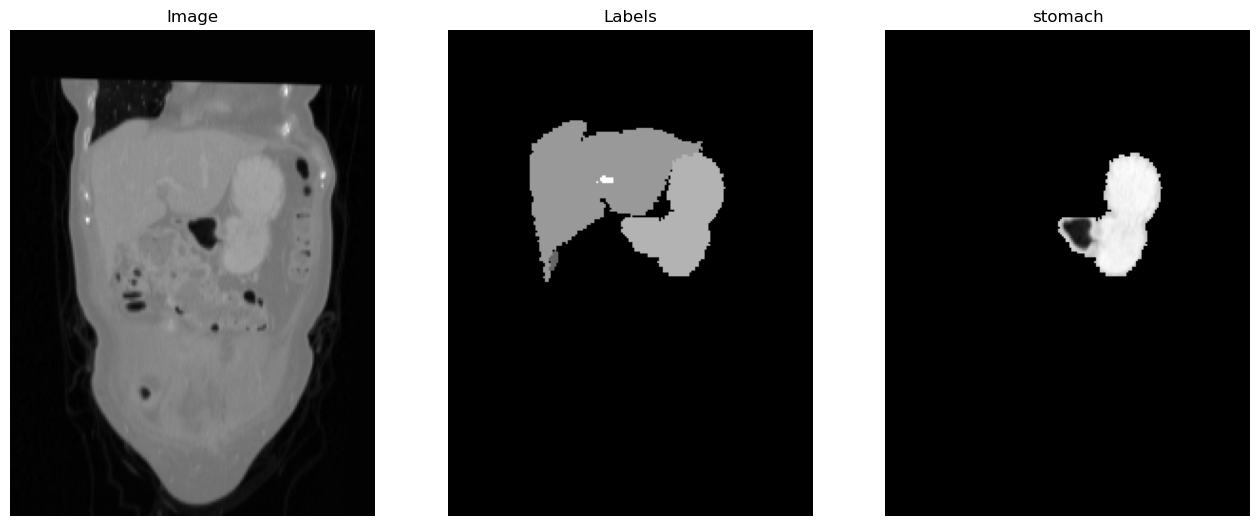

In [20]:
# preview data
img = 0
depth = 40

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16,8))
ax0.imshow(training_images[img,depth],cmap='gray')
ax0.set_title("Image")
ax0.axis("off")
ax1.imshow(training_labels[img,depth], cmap='gray')
ax1.set_title("Labels")
ax1.axis("off")
ax2.imshow(training_organ[img,depth], cmap='gray')
ax2.set_title(organs[organ])
ax2.axis("off")

# Define Model

In [10]:
# Define the input shapes
inshape = training_images.shape[1:]
nb_features = (
    (16, 32, 32), # encoder-channels
    (32, 32, 16) # decoder-channels
    )

# build model using VxmDense
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 160, 256, 192, 1), (None, 160, 256, 192, 1)
output shape: (None, 160, 256, 192, 1), (None, 160, 256, 192, 3)


In [11]:
# define loss functions
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# balance the two losses with hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [12]:
# compile model
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train model

In [13]:
# define a data generator
def training_data_generator(data, batch_size):
    vol_shape = data.shape[1:]
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        idx1 = np.random.randint(0, data.shape[0], size=batch_size)
        idx2 = np.random.randint(0, data.shape[0], size=batch_size)

        fixed_image = data[idx1, ..., np.newaxis]
        moving_image = data[idx2, ..., np.newaxis]

        inputs = [moving_image, fixed_image]
        outputs = [fixed_image, zero_phi]

        yield (inputs, outputs)

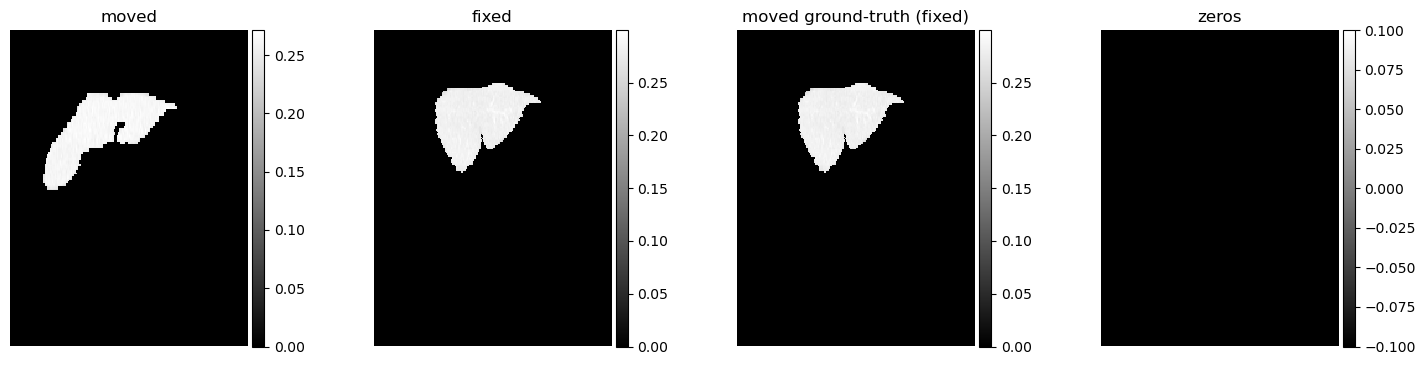

In [14]:
batch_size = 2

# define training generator
train_generator = training_data_generator(training_organ, batch_size=batch_size)
in_sample, out_sample = next(train_generator)

# view generated data
images = [img[0, depth, :, :] for img in in_sample + out_sample]
titles = ['moved', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [15]:
# train model
nb_epochs = 50
steps_per_epoch = 10
hist = vxm_model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1
)

Epoch 1/50
10/10 [==============================] - 67s 2s/step - loss: 0.0029 - vxm_dense_transformer_loss: 0.0029 - vxm_dense_flow_loss: 3.3888e-05
Epoch 2/50
10/10 [==============================] - 19s 2s/step - loss: 0.0027 - vxm_dense_transformer_loss: 0.0027 - vxm_dense_flow_loss: 1.1182e-04
Epoch 3/50
10/10 [==============================] - 19s 2s/step - loss: 0.0033 - vxm_dense_transformer_loss: 0.0032 - vxm_dense_flow_loss: 8.2772e-04
Epoch 4/50
10/10 [==============================] - 19s 2s/step - loss: 0.0029 - vxm_dense_transformer_loss: 0.0027 - vxm_dense_flow_loss: 0.0026
Epoch 5/50
10/10 [==============================] - 19s 2s/step - loss: 0.0027 - vxm_dense_transformer_loss: 0.0025 - vxm_dense_flow_loss: 0.0036
Epoch 6/50
10/10 [==============================] - 19s 2s/step - loss: 0.0022 - vxm_dense_transformer_loss: 0.0020 - vxm_dense_flow_loss: 0.0040
Epoch 7/50
10/10 [==============================] - 19s 2s/step - loss: 0.0025 - vxm_dense_transformer_loss: 0.0

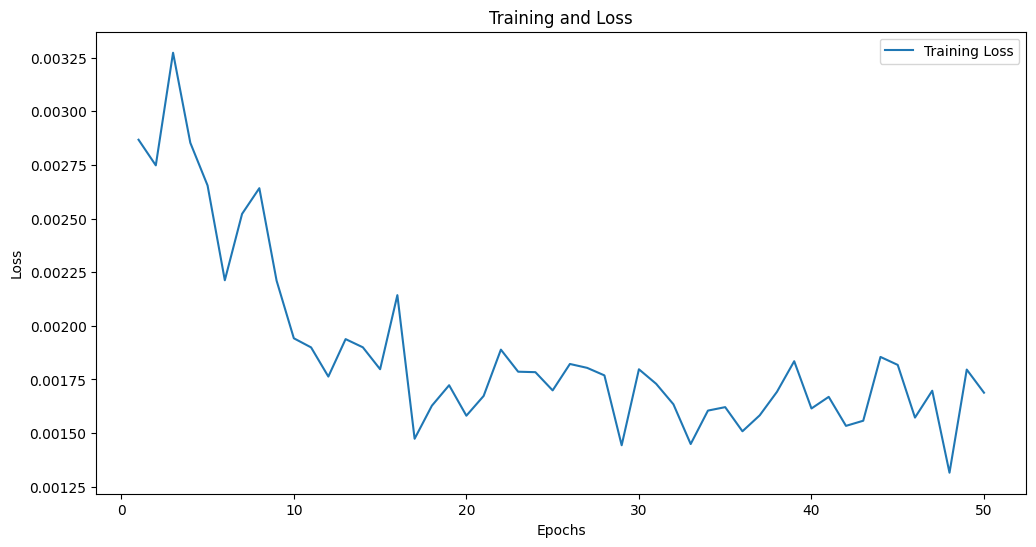

In [16]:
# extract train-loss
train_loss = hist.history['loss']

# plot history
plt.figure(figsize=(12, 6))
plt.plot(range(1, nb_epochs + 1), train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Loss')
plt.show()

# Save model

In [17]:
vxm_model.save_weights('AbdomenCTCT_'+ organs[organ] +'_model.h5')